# DeepLoc learning notebook
To use this notebook you don't need to interact with any code, just run cells in order and a graphical user interface will pop-up showcasing the parameters for each step.

In [1]:
import sys
sys.path.append('../../')
import ipywidgets as widgets
from IPython.display import display
import stackview
import datetime

import ailoc.lunar
import ailoc.deeploc
import ailoc.common
import ailoc.simulation
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
ailoc.common.setup_seed(42)

%matplotlib inline

## 1. Set the necessary parameters to train the network, mainly about the training data simulation

In [2]:
learn_param_widget = ailoc.common.SetLearnParamWidget()
learn_param_widget.display_notebook_gui()

SelectFilesButton(description='Optional: select the experiment file to estimate background range', icon='squar…

SelectFilesButton(description='Select the calibration file', icon='square-o', layout=Layout(height='80px', wid…

Button(description='Load from calib', style=ButtonStyle())

Label(value='PSF parameters', style=LabelStyle(font_weight='bold'))

SetPSFParamWidget(children=(BoundedFloatText(value=1.5, description='NA:', layout=Layout(grid_area='widget001'…

Label(value='Camera parameters', style=LabelStyle(font_weight='bold'))

Dropdown(description='CameraType:', index=1, options=('Idea Camera', 'sCMOS', 'EMCCD'), value='sCMOS')

GridspecLayout(children=(sCMOSParamWidget(children=(BoundedFloatText(value=0.81, description='QE:', layout=Lay…

SetSamplerParamWidget(children=(Label(value='Sampler parameters', layout=Layout(grid_area='widget001'), style=…

Button(description='OK', style=ButtonStyle())

Output()

## Optional: using the provided experimental image to estimate the background range

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
read first (15176, 264, 268) images


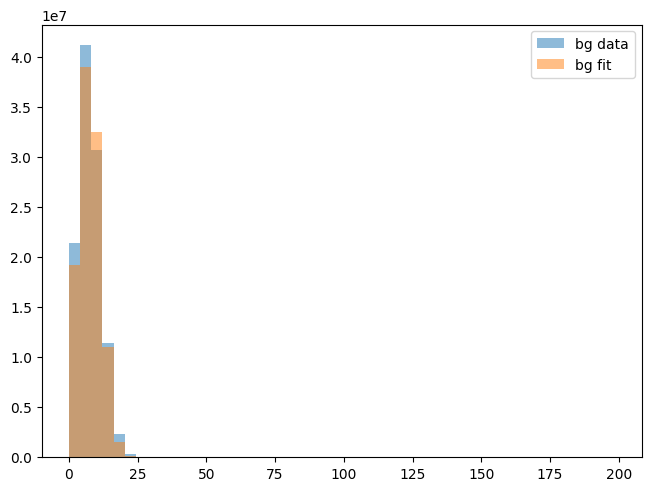

Check the parameters:
{'psf_params_dict': {'na': 1.5, 'wavelength': 670.0, 'refmed': 1.406, 'refcov': 1.524, 'refimm': 1.518, 'objstage0': -1400.0, 'zemit0': 1296.7061923583663, 'pixel_size_xy': (108.0, 108.0), 'otf_rescale_xy': (0.5, 0.5), 'npupil': 64, 'psf_size': 31, 'zernike_mode': array([[ 2., -2.],       [ 2.,  2.],       [ 3., -1.],       [ 3.,  1.],       [ 4.,  0.],       [ 3., -3.],       [ 3.,  3.],       [ 4., -2.],       [ 4.,  2.],       [ 5., -1.],       [ 5.,  1.],       [ 6.,  0.],       [ 4., -4.],       [ 4.,  4.],       [ 5., -3.],       [ 5.,  3.],       [ 6., -2.],       [ 6.,  2.],       [ 7.,  1.],       [ 7., -1.],       [ 8.,  0.]], dtype=float32), 'zernike_coef': array([ 57.251415 ,   9.445989 , -29.260118 ,  11.22918  ,  31.721521 ,        -7.1282496,  -6.159634 , -25.831396 , -17.297344 ,   9.249944 ,        13.298287 ,  39.672024 ,  -2.127104 ,   3.9348547,   2.9097912,        -2.2361004,  13.106594 ,  -0.9783758,   6.0595555,   3.2232652,        27.462757

In [3]:
if learn_param_widget.exp_file_receiver.files is not None:
    import torch
    import numpy as np
    experimental_images = ailoc.common.read_first_size_gb_tiff(learn_param_widget.exp_file_receiver.files, 2)
    camera_calib = ailoc.simulation.instantiate_camera(learn_param_widget.params_dict['camera_params_dict'])
    experimental_images = ailoc.common.cpu(camera_calib.backward(torch.tensor(experimental_images.astype(np.float32))))
    bg_range = ailoc.common.get_bg_stats_gauss(experimental_images, percentile=10, plot=True)
    
    learn_param_widget.params_dict['sampler_params_dict']['bg_range'] = bg_range
    
    print('Check the parameters:')
    dict_str = str(learn_param_widget.params_dict).replace('\n', '')
    print(dict_str)

## 2. Initialize the DL model

In [4]:
# loc_model = ailoc.deeploc.DeepLoc(learn_param_widget.params_dict['psf_params_dict'],
#                                   learn_param_widget.params_dict['camera_params_dict'],
#                                   learn_param_widget.params_dict['sampler_params_dict'])

# loc_model = ailoc.lunar.Lunar_LocLearning(learn_param_widget.params_dict['psf_params_dict'],
#                                   learn_param_widget.params_dict['camera_params_dict'],
#                                   learn_param_widget.params_dict['sampler_params_dict'])

loc_model = ailoc.lunar.Lunar_SyncLearning(learn_param_widget.params_dict['psf_params_dict'],
                                  learn_param_widget.params_dict['camera_params_dict'],
                                  learn_param_widget.params_dict['sampler_params_dict'])

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Testing network parameters and multiply-accumulate operations (MACs)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.UpsamplingNearest2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
Params:1.472M, MACs:31.550G, (input shape:torch.Size([1, 14, 64, 64]))
Average forward time: 0.0210 s


## 3. Check the PSF model used for training data simulation 

checking PSF...


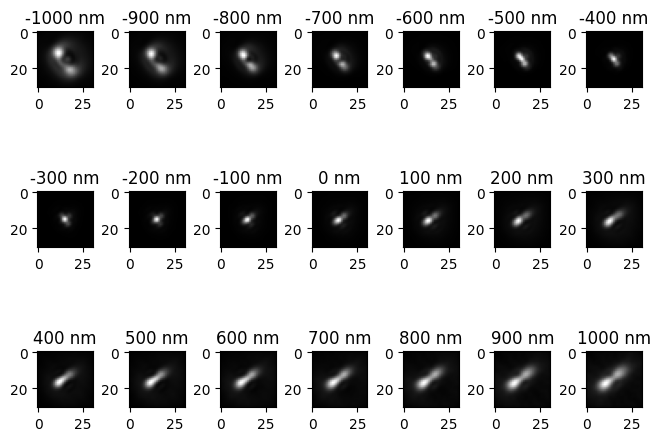

checking training data...


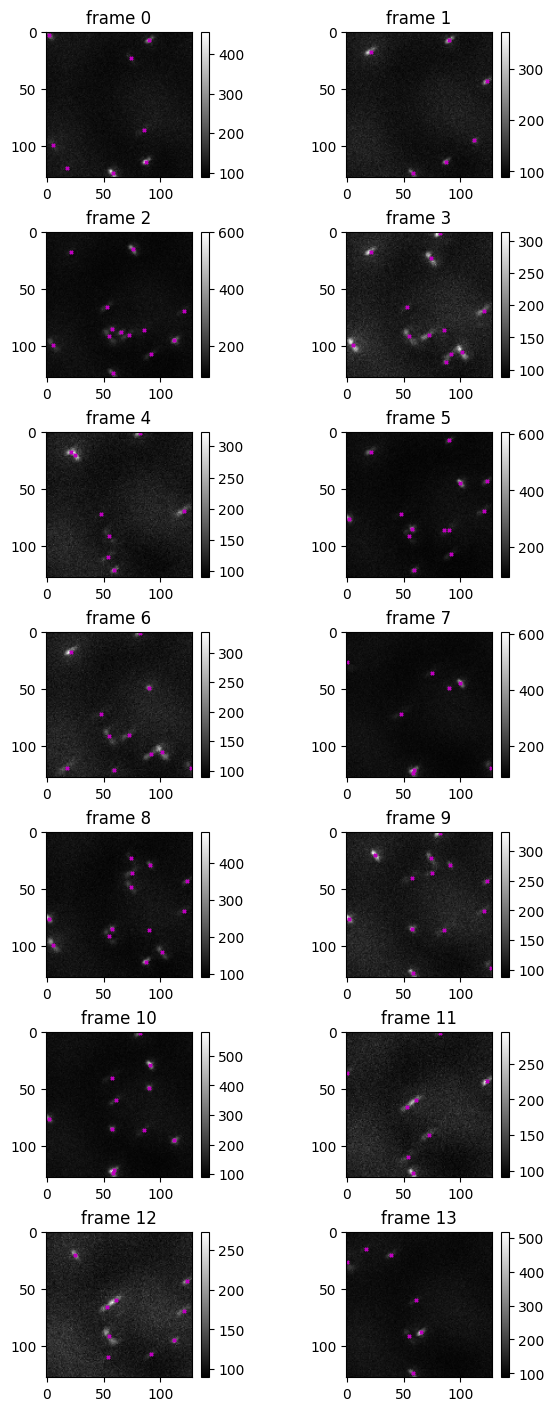

In [5]:
loc_model.check_training_psf()
loc_model.check_training_data()

## 4. Simulate a validation dataset to track the network performance

In [6]:
loc_model.build_evaluation_dataset(napari_plot=False)
display(stackview.slice(loc_model.evaluation_dataset['data'][:,0], colormap='turbo', continuous_update=True))

building evaluation dataset, this may take a while...
evaluation dataset with shape torch.Size([100, 14, 128, 128]) building done! contain 7967 target molecules, time cost: 14.26s


## 5. Your are ready to go training the network!

In [7]:
# file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'DeepLoc.pt'
# loc_model.online_train(
#         batch_size=2,
#         max_iterations=40000,
#         eval_freq=500,
#         file_name=file_name
#     )

# file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'LUNAR_LL.pt'
# loc_model.online_train(
#         batch_size=2,
#         max_iterations=40000,
#         eval_freq=500,
#         file_name=file_name
#     )

file_name = '../../results/' + datetime.datetime.now().strftime('%Y-%m-%d-%H') + 'LUNAR_SL.pt'
loc_model.online_train(
        batch_size=1,
        max_iterations=40000,
        eval_freq=1000,
        file_name=file_name,
        real_data=experimental_images,
        num_sample=100,
        wake_interval=2,
        max_recon_psfs=5000,
        online_build_eval_set=True,
    )

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Start training...
Iterations: 1000/40000 || Loss_sleep: 490.33 || Loss_wake: nan || IterTime: 410.84 ms || ETA: 4.45 h || No record found
LUNAR instance saved to ../../results/2024-12-30-13LUNAR_SL.pt


KeyboardInterrupt: 

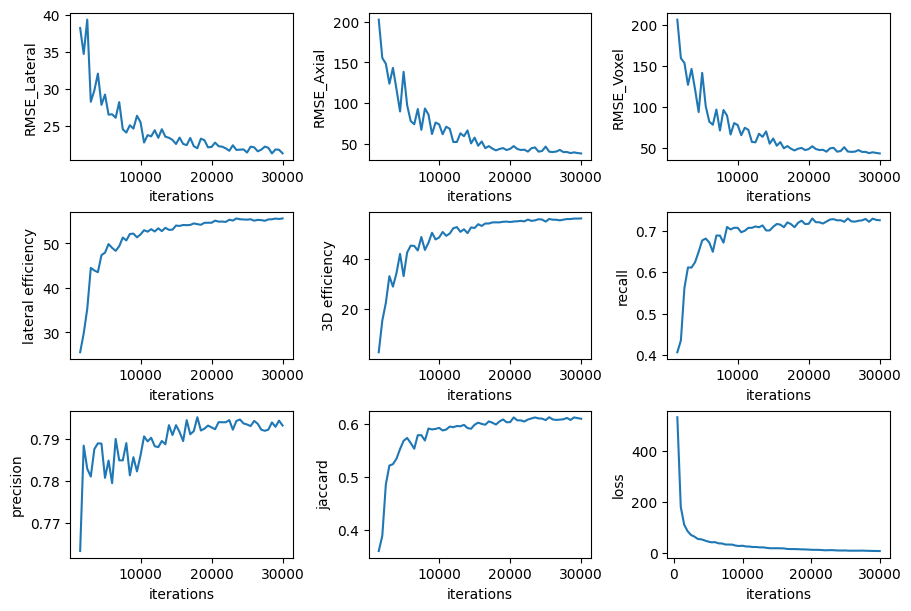

In [8]:
# # plot evaluation performance during the localization learning
# ailoc.common.plot_train_record(loc_model)

# plot evaluation performance during the synchronized learning
phase_record = ailoc.common.plot_synclearning_record(loc_model)
# save the pupil changes during the learning
imageio.mimsave('../results/' + os.path.split(file_name)[-1].split('.')[0] + '_phase.gif',
                phase_record,
                duration=200)